# Data Analysis

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from datetime import date


# Primeras aproximaciones de análisis

data_ana = pd.read_csv("data_features.csv", sep = ',', encoding="utf-8")

In [17]:
data_ana.shape

(6174, 26)

In [18]:
print(data_ana.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6174 entries, 0 to 6173
Data columns (total 26 columns):
Unnamed: 0          6174 non-null int64
Position            6174 non-null int64
Track Name          6174 non-null object
Artist              6174 non-null object
Streams             6174 non-null int64
date                6174 non-null object
spotify_id          6174 non-null object
year                6174 non-null int64
Streamstotal        6174 non-null int64
album               6174 non-null object
release_date        6174 non-null object
length              6174 non-null int64
popularity          6174 non-null int64
danceability        6174 non-null float64
danceability.1      6174 non-null float64
acousticness        6174 non-null float64
danceability.2      6174 non-null float64
danceability.3      6174 non-null float64
energy              6174 non-null float64
instrumentalness    6174 non-null float64
liveness            6174 non-null float64
loudness            6174 non-nu

In [19]:
data_ana.head(2)

,Unnamed: 0,Position,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,...,danceability.2,danceability.3,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature
0,0,1,Tusa,KAROL G,446086,2020-03-14,7k4t7uLgtOxPwTpFmtJNTY,2020,18848892,Tusa,...,0.803,0.803,0.715,0.000134,0.0574,-3.28,0.298,0.574,101.085,4
1,1,1,Tusa,KAROL G,438199,2020-03-15,7k4t7uLgtOxPwTpFmtJNTY,2020,18848892,Tusa,...,0.803,0.803,0.715,0.000134,0.0574,-3.28,0.298,0.574,101.085,4


In [20]:
data_ana.describe()

,Unnamed: 0,Position,Streams,year,Streamstotal,length,popularity,danceability,danceability.1,acousticness,danceability.2,danceability.3,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature
count,6174.000000,6174.000000,6174.000000,6174.000000,6.174000e+03,6174.000000,6174.000000,6174.000000,6174.000000,6174.000000,6174.000000,6174.000000,6174.000000,6174.000000,6174.000000,6174.000000,6174.000000,6174.000000,6174.000000,6174.000000
mean,3086.500000,98.986395,79366.921283,2019.516521,4.143814e+06,203756.327340,68.230159,0.731115,0.731115,0.244426,0.731115,0.731115,0.701424,0.006272,0.165207,-5.066344,0.106238,0.619892,121.650870,3.990606
std,1782.424613,57.566146,68027.067723,0.499767,3.420992e+06,35435.207656,17.410082,0.113484,0.113484,0.226839,0.113484,0.113484,0.147732,0.047949,0.110705,2.118782,0.080310,0.219857,31.770569,0.109084
min,0.000000,1.000000,24602.000000,2019.000000,2.902700e+04,106000.000000,0.000000,0.218000,0.218000,0.000274,0.218000,0.218000,0.056100,0.000000,0.037100,-23.023000,0.023200,0.051700,65.375000,3.000000
25%,1543.250000,50.000000,38691.250000,2019.000000,1.962385e+06,177240.000000,63.000000,0.676000,0.676000,0.062300,0.676000,0.676000,0.622000,0.000000,0.091000,-5.725000,0.050500,0.480000,95.993000,4.000000
50%,3086.500000,99.000000,50774.500000,2020.000000,3.065967e+06,200266.000000,71.000000,0.745000,0.745000,0.175000,0.745000,0.745000,0.729000,0.000000,0.114000,-4.669000,0.070200,0.662000,104.965000,4.000000
75%,4629.750000,148.000000,89316.750000,2020.000000,5.267080e+06,223480.000000,78.000000,0.806000,0.806000,0.327000,0.806000,0.806000,0.796000,0.000018,0.218000,-3.713000,0.137000,0.789000,147.982000,4.000000
max,6173.000000,200.000000,495344.000000,2020.000000,1.884889e+07,464200.000000,100.000000,0.925000,0.925000,0.952000,0.925000,0.925000,0.973000,0.465000,0.685000,-1.953000,0.490000,0.973000,195.801000,5.000000


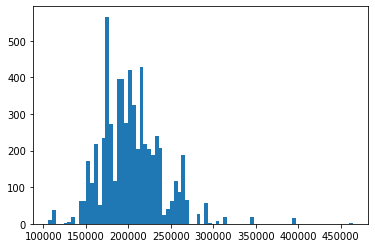

In [9]:
plt.hist(data_ana['length'], bins = 80)
plt.show()

In [ ]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(data_ana, data_ana.columns, 3000, 15)


/Users/victormac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  import sys


In [ ]:
sns.pairplot(data_ana)